In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [20]:
def compute_CUSUM(X):
    T = len(X)
    CUSUM = np.zeros(T)
    for k in range(1, T + 1):
        CUSUM[k - 1] = np.sum(X[:k] ** 2)
    return CUSUM

# def compute_CUSUM(X):
#     N = len(X)
#     CUSUM = np.zeros(N)
#     CUSUM[0] = X[0] ** 2
#     for k in range(1, N):
#         CUSUM[k] = CUSUM[k-1] + X[k]**2
#     return CUSUM


def compute_gamma(X, T, m):
    gamma = np.zeros(m + 1)
    mean_X = np.mean(X)
    r = X - mean_X
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)

    for i in range(0, m + 1):
        gamma_i = 0
        for t in range(i + 1, T+1):
            gamma_i += (r_squared[t - 1] - sigma_squared) * (r_squared[t - i - 1] - sigma_squared)
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    D_prime = np.zeros(T)
    for k in range(0, T):
        D_prime[k] = (CUSUM[k] - ((k + 1) / T) * CUSUM[-1]) / np.sqrt(lambda_hat)
    return D_prime


def compute_percentile(D_prime, T, percent=99):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value

In [21]:
# def compute_KWtest(X, change_points:list):
#     KW = (12/(len(X)*(len(X)+1))*(sum())

In [22]:
N = 1000
T = N
np.random.seed(0)
X = np.random.normal(0, 1, N)
jump_magnitude = 20
jump_position = N // 2
X[jump_position:] += jump_magnitude

# Neway-West 통계량의 최대시차
m = round(T ** (1 / 4))

In [23]:
# CUSUM 계산
CUSUM = compute_CUSUM(X)

# gamma 계산
gamma = compute_gamma(X, T, m)

# lambda_hat 계산
lambda_hat = compute_lambda(gamma, m)

In [24]:
# D_prime 계산
D_prime = compute_D_prime(CUSUM, T, lambda_hat)

In [25]:
critical_value = compute_percentile(D_prime, T, percent=99)

In [26]:
ol_lst = list(np.where((np.abs(D_prime) * np.sqrt(T / 2) > critical_value))[0])
print(ol_lst)

[494, 495, 496, 497, 498, 499, 500, 501, 502, 503]


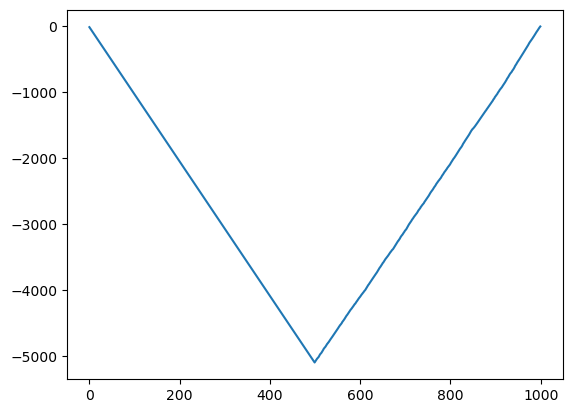

In [27]:
plt.plot(D_prime)

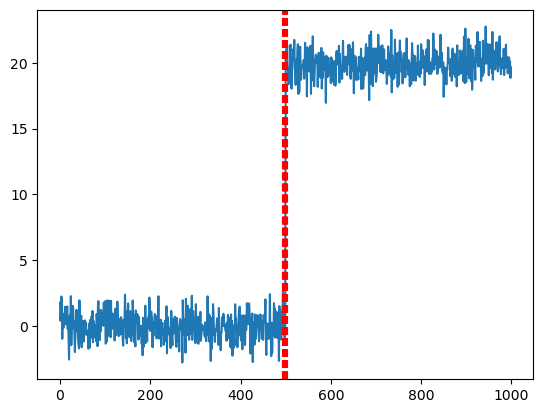

In [28]:
plt.plot(X)
for val in ol_lst:
    plt.axvline(val, color='r', linestyle='--')

In [29]:
info_wo_tle_df = pd.read_csv('File/info_wo_tle_df.csv', index_col=0)
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', name]]

In [30]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_1 = df_1.resample('h').mean()

In [31]:
# df_1 = df_1.rolling(window=120).mean().dropna()
df_2 = df_1.diff().dropna().values

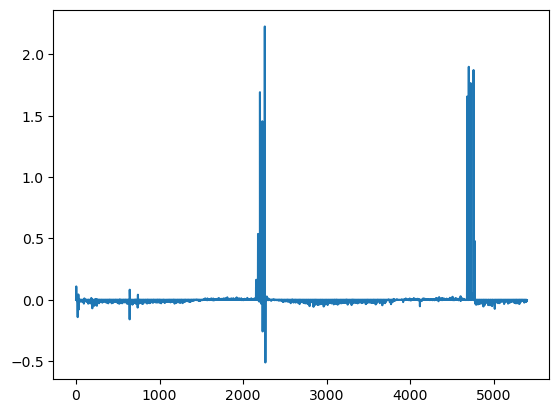

In [32]:
plt.plot(df_2)

In [33]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_2)
print('ADF')
print(f'Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')
print('---' * 40)

result = kpss(df_2)
print('KPSS')
print(f'Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[3]}')
print('---' * 40)

ADF
Statistics: -6.803794134222781
p-value: 2.2028338486368704e-09
Critical values: {'1%': -3.4315692379749074, '5%': -2.862078779432107, '10%': -2.56705679155445}
------------------------------------------------------------------------------------------------------------------------
KPSS
Statistics: 0.5200638379748717
p-value: 0.037147784239893775
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


In [34]:
window_size = 1000
lambda_lst = []
cv_lst = []
current_lst = []

for i in tqdm(range(window_size, len(df_2), 1)):
    X = df_2[i - window_size:i]
    T = len(X)
    m = round(T**(1/4))

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)

    # gamma 계산
    gamma = compute_gamma(X, T, m)

    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)
    lambda_lst.append(lambda_hat)
    # D_prime 계산

    D_prime = compute_D_prime(CUSUM, T, lambda_hat)

    critical_value = compute_percentile(D_prime, T)
    cv_lst.append(critical_value)
    current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

100%|██████████| 4399/4399 [03:16<00:00, 22.34it/s]


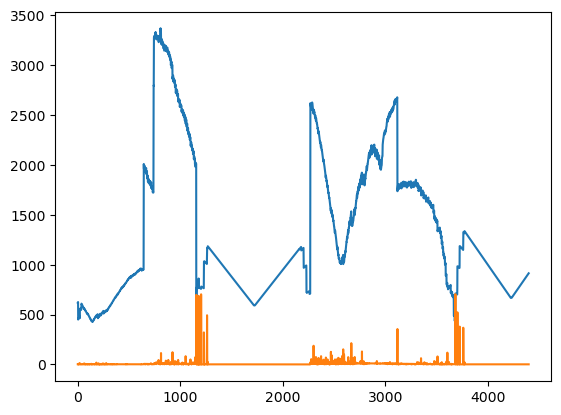

In [35]:
#plt.plot(lambda_lst)
plt.plot(cv_lst)
plt.plot(current_lst)

In [36]:
ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)

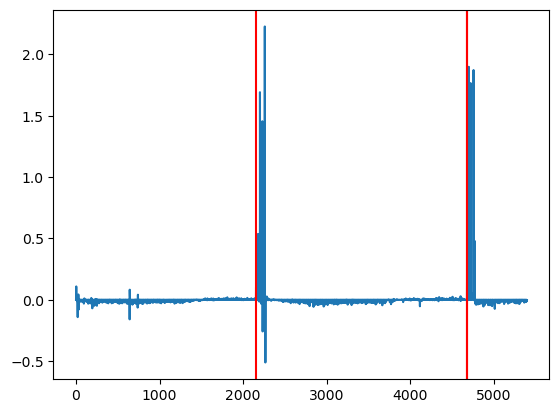

In [37]:
plt.plot(df_2)
for point in ol_lst:
    plt.axvline(point, color='r')

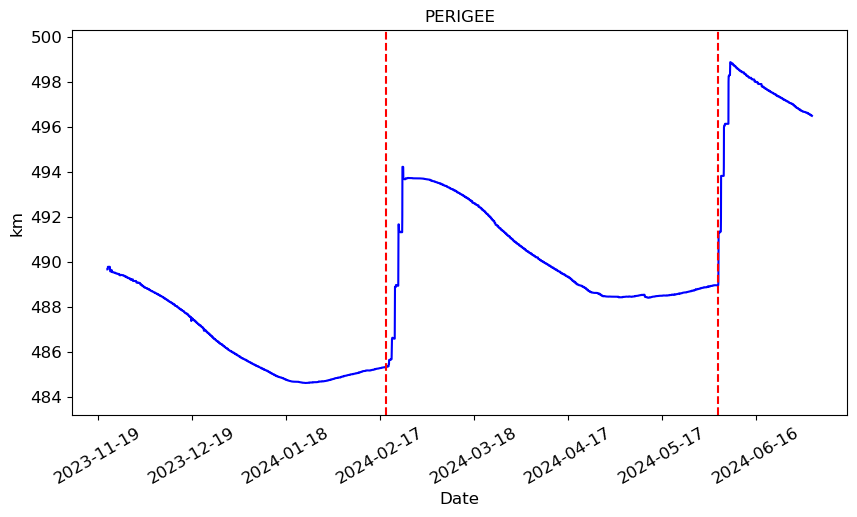

In [38]:
draw_graph(df_1, name.upper(), 'km',
           pd.DataFrame(df_1.iloc[ol_lst].index.date).drop_duplicates().values.tolist(), "blue")